# Planting Analysis

The script below imports planting dates and uses them to generate model outputs. 

Last updated: 11 June 2020

In [11]:
# import packages and set working directory
import numpy as np
import matplotlib.pyplot as plt
import os
from math import exp
import pandas as pd
import seaborn as sns
import proplot as plot
import sys
import datetime

# We need to add the module path to our system path so 
# so that our notebook can find our local objects and code:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
# import objects
from farm import Climate
from farm import Soil
from farm import Crop
from farm import CropModel
from farm.functions import *

# set background color
plot.rc['figure.facecolor'] = 'white'
plot.rc.axesfacecolor = 'white'

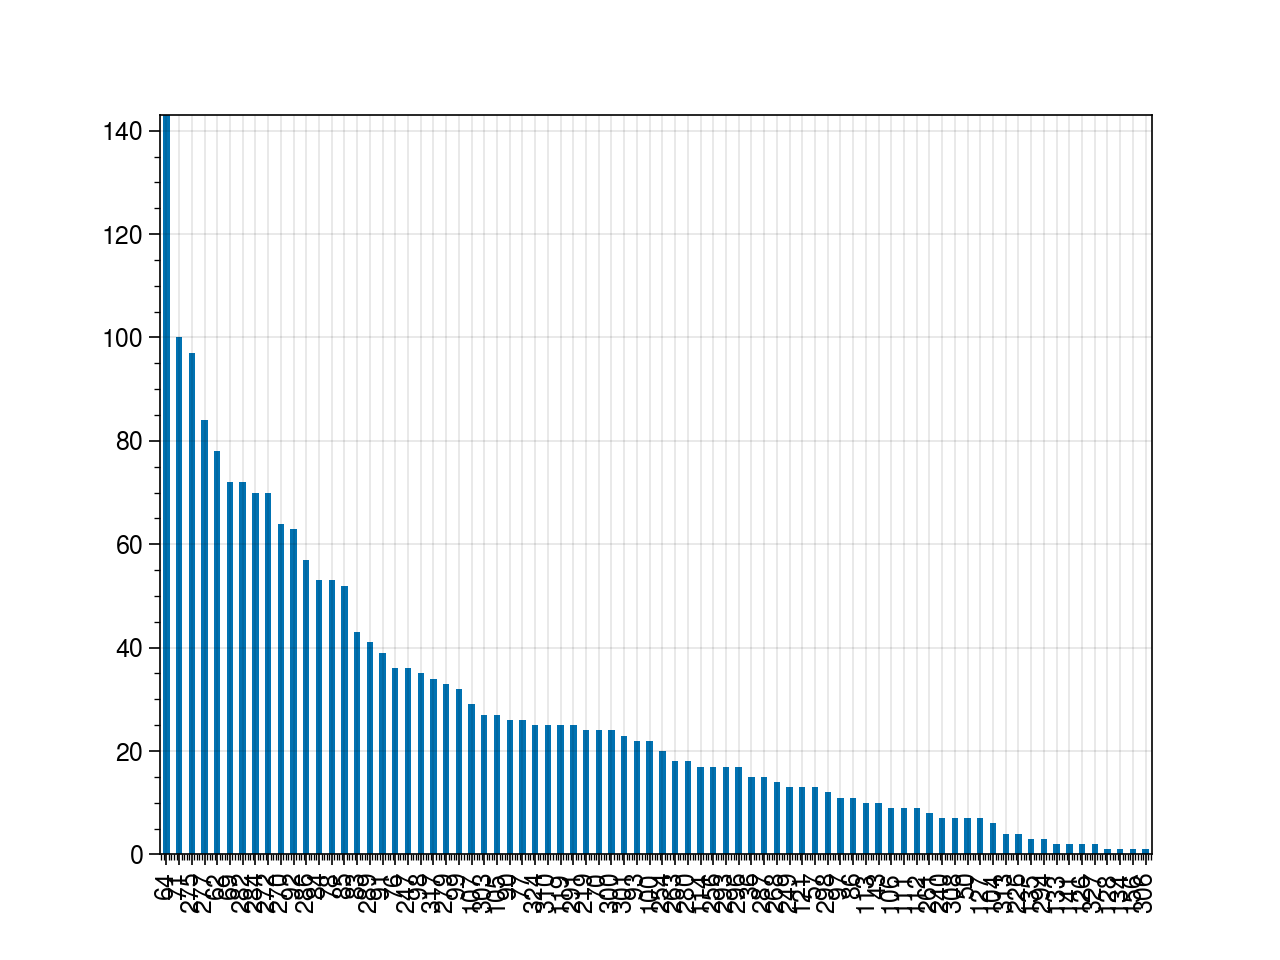

In [69]:
# data import will require file that is only available on Natasha's machine 

pds = pd.read_csv('../../../Kenya/planting-analysis/data/primary/SMS/L5/all_data_for_summary.csv',sep=',').drop(['Unnamed: 0','Latitude','Longitude'], axis=1); pds

# Convert datetime to Day of Year
pds['PD'] = pd.to_datetime(pds['PD'], errors='coerce')
pds['DOY'] = pds['PD'].dt.dayofyear

# Check out the distribution
#pds['DOY'].hist()

# Plug in these values for model runs
PDS = pds.DOY.tolist()

# TODO: Do I need only one farmer per planting date
# Or do some kind of weight based on planting date

# Frequency plots of planting date
pds['DOY'].value_counts().plot(kind='bar')


In [74]:
# get list of unique planting dates

uniquePDS = result.PDS.unique()

In [37]:
def total_rf_corr(n_sim = 500, station = 'OL JOGI FARM', texture = 'clay', lgp=180, pd_sim=100): 
    """ Run simulations for a specific climate, soil, and crop.

    Usage: total_rf_corr(n_sim, pd_ic, station, texture, lgp, pd_sim)
           
    Default values:
        n_sim = 500 # Number of Simulations to Remove Initial Conditions [integer]
        pd_ic = 1 # Planting Date for Initial Conditions [Julian day]
        station = 'OL JOGI FARM' # Climatology [string]
        texture = 'loam' # Soil Type [string]
        lgp = 180 # Length of Growing Period [Days]
        pd_sim 100 # Planting Date for Simulation [Julian day]

    """
    # Part 1. Set conditions for IC runs
    n_sim = n_sim # change back to 1000 later
    planting_date = pd_sim 

    # Part 2. Initialize model with a climate, soil and crop
    climate = Climate(station=station)
    soil = Soil(texture=texture)
    crop = Crop(soil=soil, lgp=lgp)
    soil.set_nZr(crop)

    model = CropModel(crop=crop, climate=climate, soil=soil)
    model.run()
    o = model.output()

    # Part 3. Get the mean, SD soil moisture and run the simulations to remove IC
    s0_mean, s0_std = average_soil_moisture(model, n_sims=n_sim, doy=planting_date)
    models = [CropModel(crop=crop, climate=Climate(), soil=soil) for i in np.arange(n_sim)]
    
    # Part 4. Run the actual simulations
    output = [model.run(s0=s0_mean, do_output=True, planting_date=planting_date) for model in models]

    # Part 5. Subset the growing period and get avg stress, total rf
    start = 21 
    end = start + lgp
    avg_stress = [df[start:end]['stress'].mean() for df in output]
    total_stress = [df[start:end]['stress'].sum() for df in output]

    # dont need this but helpful for debugging
    total_rf = [df[start:end]['R'].sum() for df in output]
    avg_s = [df[start:end]['s'].mean() for df in output]

    o = output
    # Part 6. Output the dynamic stress and yield values
    # prev crop.calc_dstress
    x = [crop.calc_dstress(s=df.s, stress=df.stress) for df in o] #for i in np.arange(n_sim)
    #print(x)
    return  x, total_rf # output, avg_stress, total_stress, total_rf,, mstr_memb, dstr_memb, yield_kg_ha


In [55]:
# make subset of PDs because this is taking too long
test_PDS = [50,100,100,200,250]

In [65]:
len(PDS)

2187

In [79]:
# run results for all planting dates
# TODO: Split these into 2 or 3 seasons

result = []

for i in uniquePDS:
    
    data, rf = total_rf_corr(n_sim = 50, station = 'OL JOGI FARM', texture = 'loam', lgp=180, pd_sim=i)
    df = pd.DataFrame.from_records(data, columns =['AvgStress2','DynamicStress','Yield'])
    df['RF'] = rf
    df['PDS'] = i
    result.append(df)
    
result = pd.concat(result)


0.7470710736510848
m -0.0006630961087159316
b 0.5065112634734782


<Figure size 500x400 with 0 Axes>

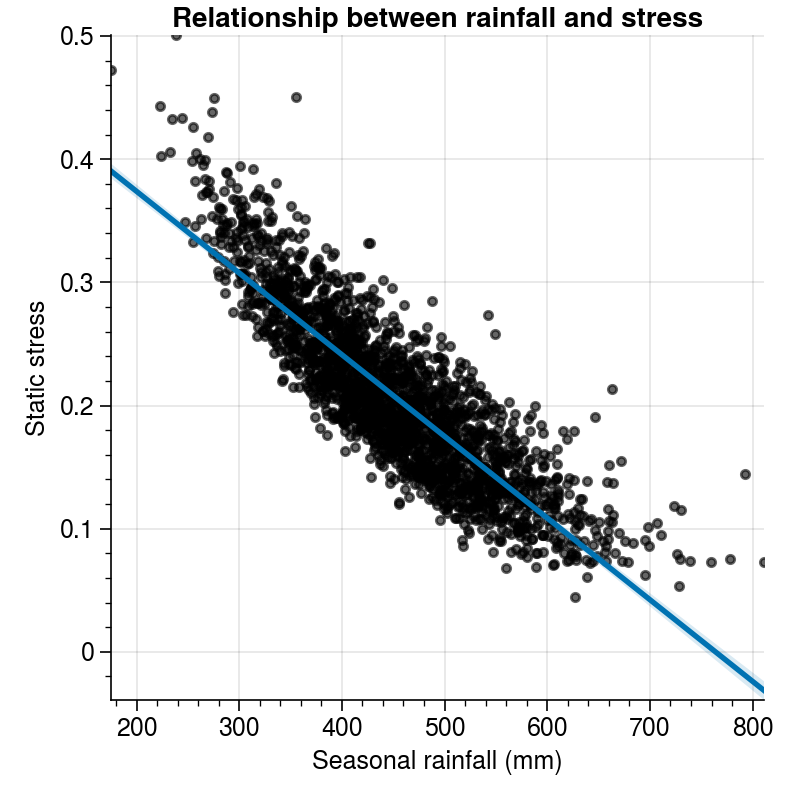

In [42]:
result

# Static stress
# make some lin regressions
plot_lin_regression(result.RF, result.AvgStress2, 'RF','AvgStress2',result, 'Seasonal rainfall (mm)', 'Static stress', 'Relationship between rainfall and stress')


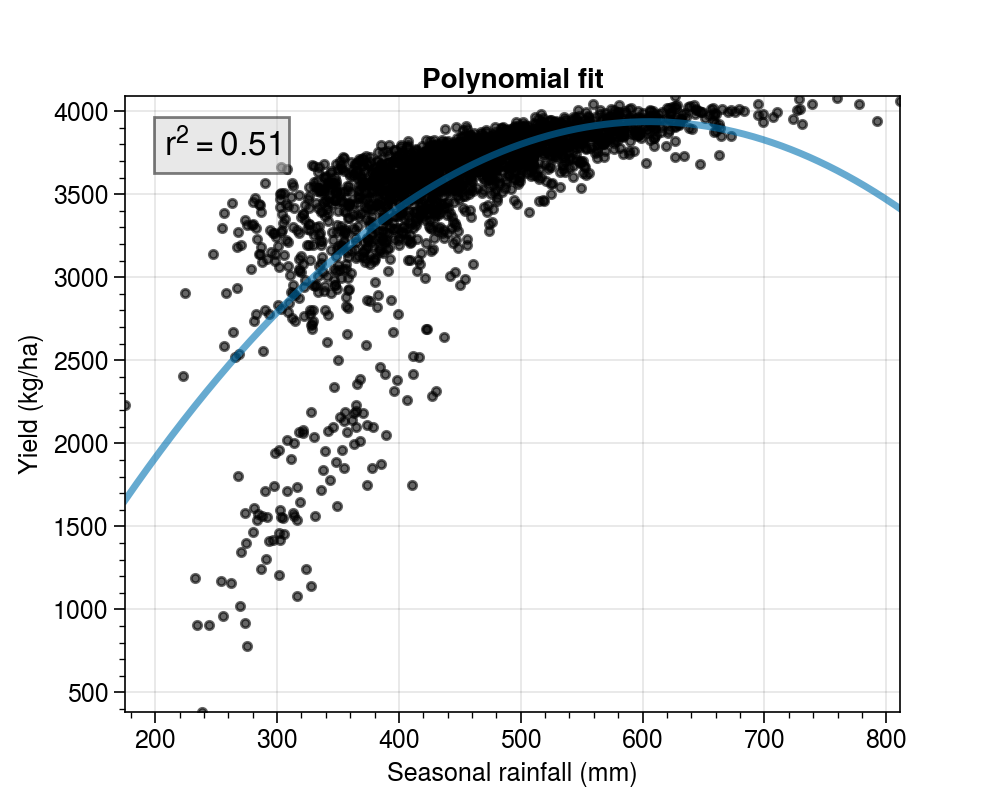

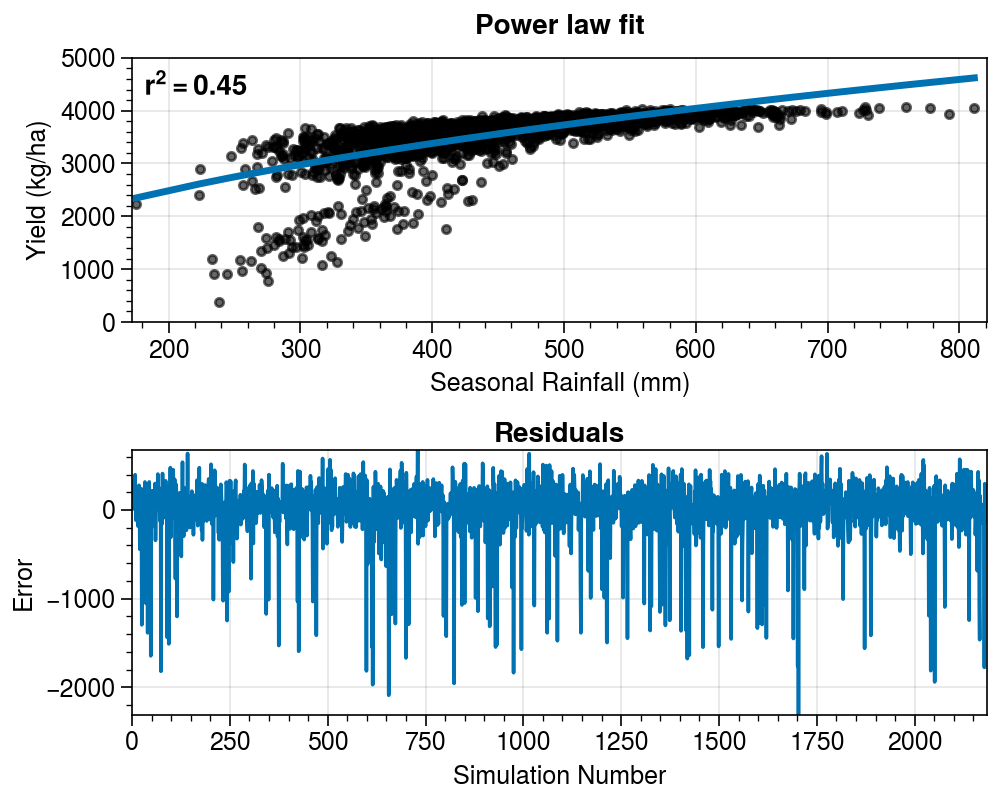

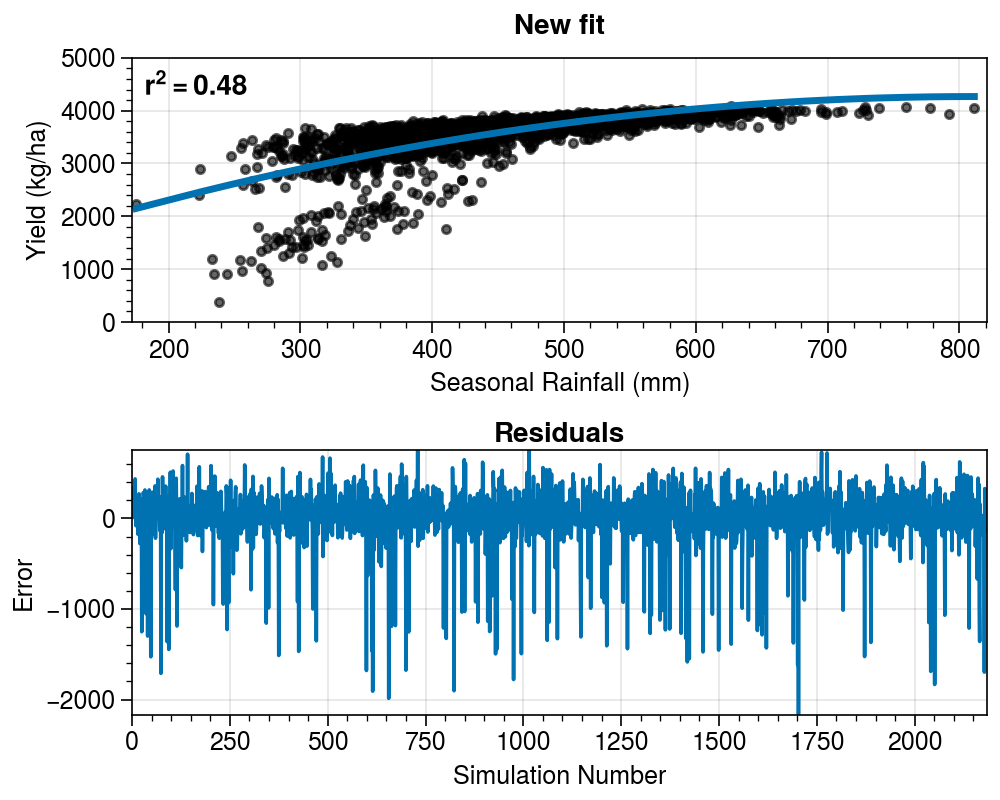

In [44]:
# Dynamic stress
result.PDS.min()

# Fit curves
df = result

# lin regression is not what we want; try quadratic
plot_polyfit(x=df.RF, y=df.Yield, degree=2)

# try power law
power_law_fit(df.RF, df.Yield,'Seasonal Rainfall (mm)', 'Yield (kg/ha)', 'Power law fit')

# New fit
plot_newfit(df.RF, df.Yield, 'Seasonal Rainfall (mm)', 'Yield (kg/ha)', 'New fit')

#TODO: FIt logarithmic curve

In [135]:

# make the results data easier to plot
data = result.pivot(columns='PDS',values='Yield')
data.name = 'Yield (kg/ha)'

data.columns

data = pd.DataFrame(
    data,
    columns=pd.Index(data.columns, name='Planting Date')
)

data


Planting Date,36,43,50,57,62,64,69,70,71,76,...,300,301,303,306,308,310,313,317,324,327
0,3157.709778,3560.494829,3708.169141,3890.655228,3794.796476,3675.111560,3676.756991,3837.735094,3790.073232,3632.361214,...,3329.546131,3666.843700,3704.962676,3617.694970,3485.624661,3582.548970,3318.754420,3710.533271,3796.453609,3718.372163
1,3471.003445,3557.065246,3949.466400,3815.491763,3956.064024,3539.203154,3686.087503,3922.853821,3744.989258,3733.245723,...,3448.171789,3630.996311,3779.225812,3646.587913,3870.095853,3835.150777,3728.676602,3777.981034,3683.834437,3595.451005
2,3765.169959,3846.868487,3619.052174,3098.500071,1300.569961,3709.159253,2873.932450,3736.266014,3862.003551,3345.040944,...,3804.426236,3370.194843,3972.321782,3885.465818,3086.603615,3653.992535,3534.682359,3761.420686,3051.169520,3221.359654
3,3571.594404,3086.358462,2994.532379,3929.324196,3683.804639,3586.061526,4011.190561,3798.119967,3982.950872,3688.536069,...,3692.577294,3692.541840,3774.978299,3695.338243,3870.593780,3850.881827,1005.570072,3787.417836,3639.177224,3215.785630
4,3691.825878,3684.462557,3686.497784,3754.420782,3333.907351,3659.391471,3628.136298,3737.395617,3578.141239,3740.208660,...,3739.613279,2693.898606,2756.459123,3572.868625,3681.572906,3573.436876,3429.526549,3904.403138,3709.270038,3599.687579
5,2116.380738,3670.147111,3369.261570,3749.764374,3597.814397,3848.382826,3894.278826,3919.596949,3761.701933,3892.115333,...,3615.818704,3351.214883,3687.899327,3282.054239,3799.012840,3879.254971,3667.207202,3222.252096,3421.592288,3458.406251
6,3464.710967,3113.761340,3687.059300,3880.190024,3764.141386,3680.117202,3960.446874,3648.728366,3801.656783,3638.892532,...,3818.047549,3615.253631,3483.160018,3830.348289,3749.644629,3815.278286,3868.755719,3518.028374,3885.389146,3455.818966
7,3679.407274,3780.625249,3808.290739,3528.706262,3867.250645,3518.063397,3849.719723,3702.170213,3660.807790,3957.391119,...,3780.757208,3664.556134,3891.072026,3865.409789,3715.719202,3767.559730,3384.573336,3739.649553,3817.523204,3665.867647
8,3752.922950,3453.982656,3675.794401,3833.590099,3436.196215,3913.983208,3836.333452,3703.862112,3782.776546,4012.984072,...,3434.379293,3686.456146,3720.115701,3478.731984,3544.723391,3877.346845,3807.041072,3763.485305,3698.006105,3576.417054
9,3802.558975,3856.319166,3540.486111,3778.218357,3440.909289,3500.646171,3858.798925,3323.330219,3884.969984,3343.349830,...,3728.638450,3483.620080,3828.097008,3695.845892,3942.588534,3725.440880,3989.851896,3802.534953,3987.409007,3789.989583


In [105]:
result.PDS.min()
result.PDS.max()

327

In [141]:
data.columns

Int64Index([ 36,  43,  50,  57,  62,  64,  69,  70,  71,  76,  77,  78,  83,
             84,  85,  86,  90,  91,  92,  93,  97,  98,  99, 100, 104, 105,
            106, 107, 111, 112, 113, 114, 119, 121, 126, 127, 128, 133, 134,
            135, 141, 156, 219, 226, 240, 247, 249, 254, 256, 261, 263, 268,
            270, 272, 275, 277, 279, 280, 282, 284, 286, 287, 289, 291, 293,
            294, 296, 298, 300, 301, 303, 306, 308, 310, 313, 317, 324, 327],
           dtype='int64', name='Planting Date')

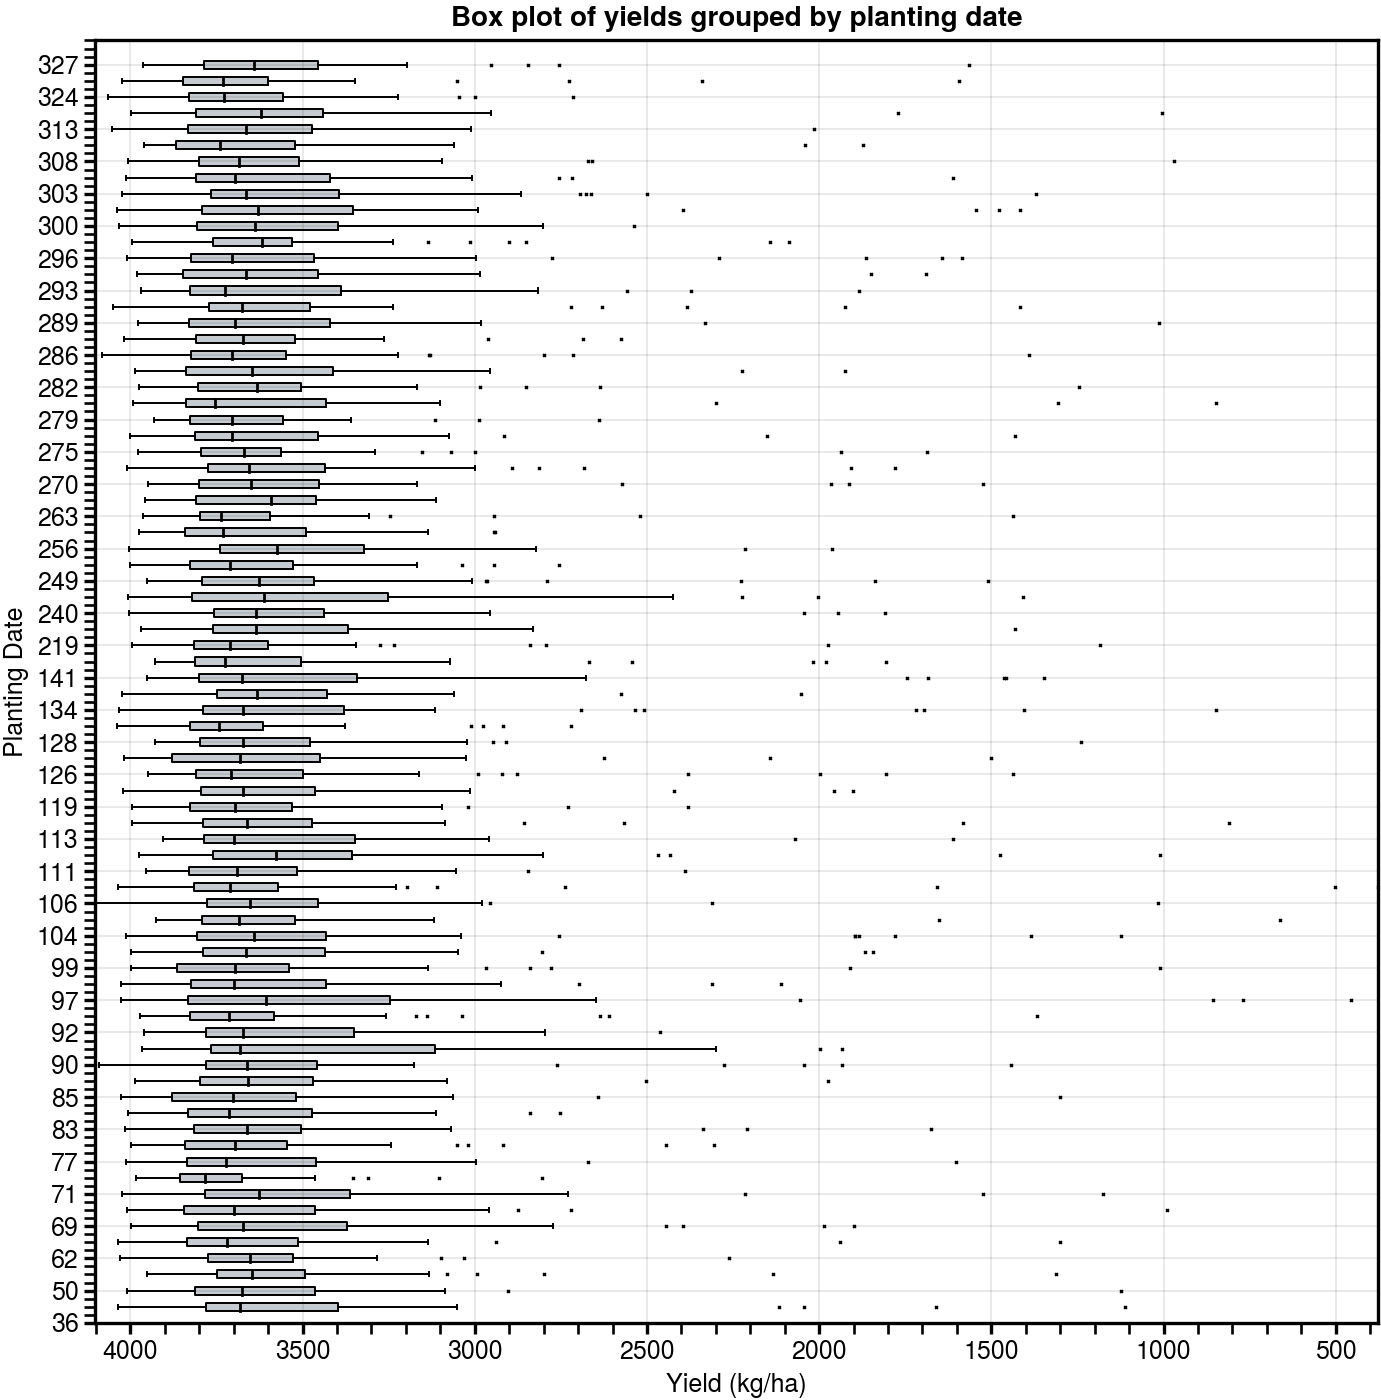

In [162]:
plot.rc.update(
    linewidth=1.2, fontsize=3, ticklenratio=1,
    figurefacecolor='w', facecolor='white',
    titleloc='upper center', titleborder=False,
)

# Fit boxplots to planting dates
result.PDS.nunique()

#result.boxplot(column='Yield', by='PDS')

# Generate figure
fig, axs = plot.subplots(ncols=1, axwidth=2.5, height=7)
axs.format(grid=True, suptitle='Box plot of yields grouped by planting date')

# Box plots
ax = axs[0]
obj1 = ax.boxplot(
    data, lw=0.7, marker='x', fillcolor='gray5',markersize=1,orientation='horizontal',
    medianlw=1, mediancolor='k'
)
ax.format(ylabel='Planting Date') #, title='Bar plot', ygrid=False)

ax.format(xlabel='Yield (kg/ha)') #, title='Bar plot', ygrid=False)

# User input labels
axs[0].format(
    ylim=(0, 79.5), ylocator=2,
# deleted every other one
            yticklabels=[ '36',   '50',    '62',   '69',  '71',  '77',    '83',
             '85',   '90',   '92',   '97', '99',  '104', 
            '106',  '111',  '113',  '119',  '126',  '128',  '134',
           '141',  '219',  '240',  '249',  '256',  '263', 
        '270',  '275',  '279',  '282',  '286',  '289',  '293',
             '296',  '300',  '303',  '308', '313',  '324','327']
)

# actual labels
  #  yticklabels=[ '36',  '43',  '50',  '57',  '62',  '64',  '69',  '70',  '71',  '76',  '77',  '78',  '83',
  #           '84',  '85',  '86',  '90',  '91',  '92',  '93',  '97',  '98',  '99', '100', '104', '105',
  #          '106', '107', '111', '112', '113', '114', '119', '121', '126', '127', '128', '133', '134',
  #          '135', '141', '156', '219', '226', '240', '247', '249', '254', '256', '261', '263', '268',
  #      '270', '272', '275', '277', '279', '280', '282', '284', '286', '287', '289', '291', '293',
  #          '294', '296', '298', '300', '301', '303', '306', '308', '310', '313', '317', '324', '327']

#ax.format(title='Box plots', titleloc='uc')

# Violin plots
#ax = axs[1]
#obj2 = ax.violinplot(
#    data, lw=0.7, fillcolor='gray7',
#    points=500, bw_method=0.3, means=True
#)
#ax.format(title='Violin plots', titleloc='uc')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x14026dd30>,
      dtype=object)

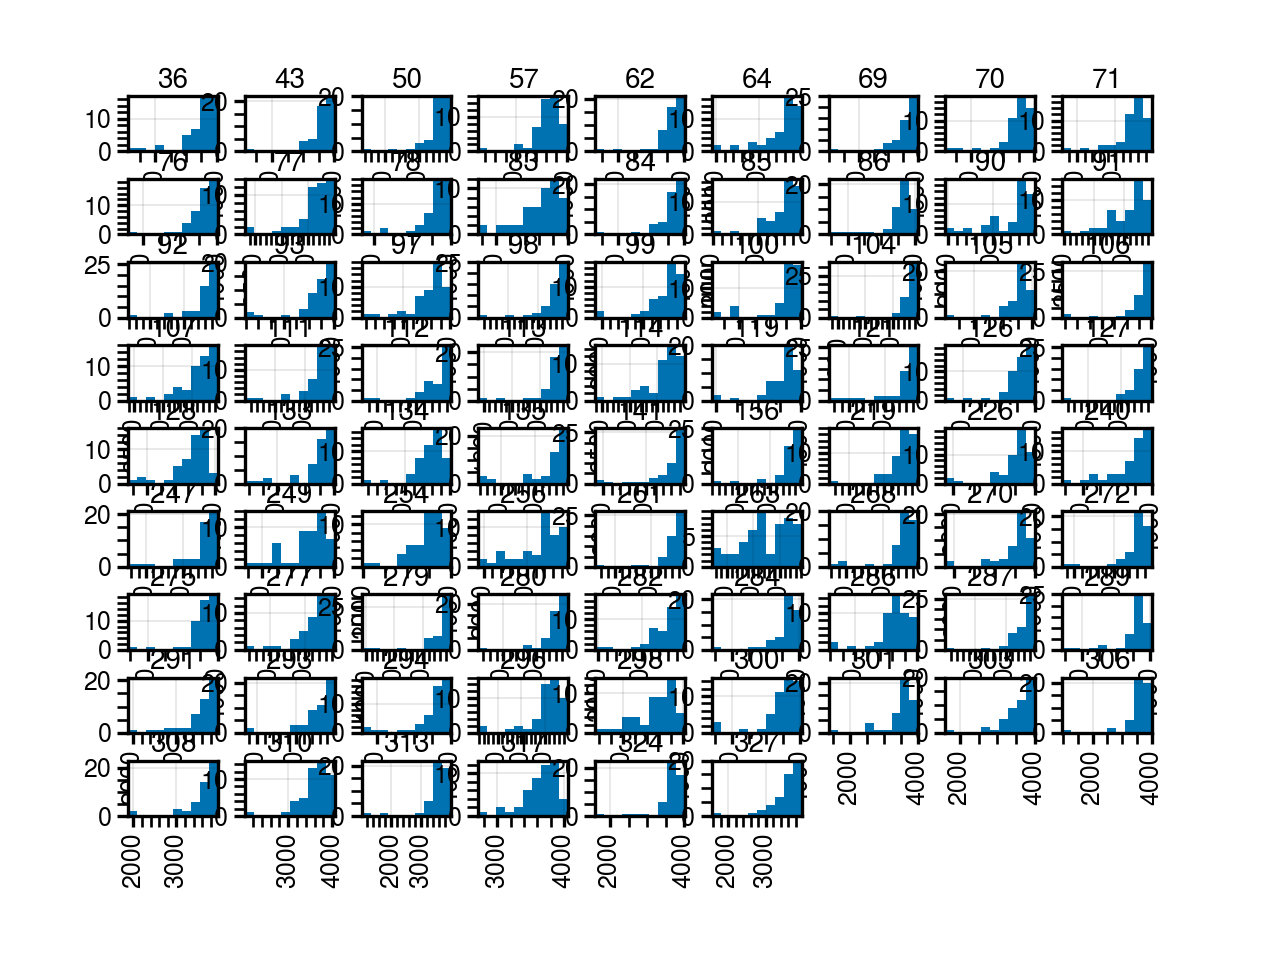

In [163]:
result.groupby('PDS')['Yield'].mean()

result.Yield.hist(by=result.PDS)

In [172]:
for col in data.columns: #np.arange(1, 78):
    #ax = axs[col - 1]
    #ax.set_title(month_abbrs[mth])
    #result.Yield.hist(by=result.PDS)
    sns.distplot(list(data[col]), ax=ax, **{'kde': False})

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()